In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_array, check_X_y

import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt

import seaborn as sns  # データ可視化ライブラリ
from lightning.pytorch import seed_everything

from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn.cluster import KMeans
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray

from typing import Optional

from kmodes.kprototypes import KPrototypes
import gower

plt.style.use("ggplot")
seed_everything(8)

Seed set to 8


8

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

# 例のデータセット
data = pd.DataFrame(
    {
        "Category": ["A", "B", "A", "C", "B", "C"],
        "Value1": [10, 20, 15, 30, 25, 35],
        "Value2": [1.5, 2.3, 1.8, 3.6, 2.8, 3.9],
    }
)

# 1. カテゴリ変数をワンホットエンコーディング
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data[["Category"]])

# ワンホットエンコーディングの結果をDataFrameに変換
encoded_df = pd.DataFrame(
    encoded_features, columns=encoder.get_feature_names_out(["Category"])
)

# オリジナルの数値データと結合
processed_data = pd.concat([data.drop(columns=["Category"]), encoded_df], axis=1)

print("ワンホットエンコーディング後のデータ:")
print(processed_data)

# 2. KMeansクラスタリング
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# 結果をデータフレームに追加
data["Cluster"] = clusters

# クラスタリング結果を表示
print("\nクラスタリング結果:")
print(data)

# 3. シルエットスコアの計算（クラスタリングの評価）
score = silhouette_score(processed_data, clusters)
print(f"\nシルエットスコア: {score:.2f}")


ワンホットエンコーディング後のデータ:
   Value1  Value2  Category_A  Category_B  Category_C
0      10     1.5         1.0         0.0         0.0
1      20     2.3         0.0         1.0         0.0
2      15     1.8         1.0         0.0         0.0
3      30     3.6         0.0         0.0         1.0
4      25     2.8         0.0         1.0         0.0
5      35     3.9         0.0         0.0         1.0

クラスタリング結果:
  Category  Value1  Value2  Cluster
0        A      10     1.5        0
1        B      20     2.3        0
2        A      15     1.8        0
3        C      30     3.6        1
4        B      25     2.8        0
5        C      35     3.9        1

シルエットスコア: 0.45


c:\Users\tsuki\Desktop\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


<!-- # データの前処理 -->

In [22]:
# 外れ値の除去
def remove_outliers_zscore(data, metric, threshold=2):
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [29]:
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\NHANES_age_prediction.csv"
)
df1 = df1.drop(columns=["SEQN", "age_group"])
print("外れ値除外前", df1.shape)

obj1 = "BMXBMI"
df1 = remove_outliers_zscore(df1, obj1)
df1 = df1.reset_index(drop=True)
print("外れ値除外後", df1.shape)

features_list1 = [
    "RIDAGEYR",  # 年齢（連続変数）
    "RIAGENDR",  # 性別（1:Male, 2:Female)
    "PAQ605",  # 運動有無(1:日常的に運動する, 2:運動しない)
    "LBXGLU",  # 断食後の血糖値（連続変数）
    "DIQ010",  # 糖尿病の有無(0:なし、1:あり)
    "LBXGLT",  # 口内の健康状態（連続変数）
    "LBXIN",  # 血中インスリン濃度（連続変数）
]

numerical_features = ["RIDAGEYR", "LBXGLU", "LBXGLT", "LBXIN"]
catagorical_features = ["RIAGENDR", "PAQ605", "DIQ010"]
X_numerical = df1[numerical_features]
X_catagorical = df1[catagorical_features]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(X_numerical)
X_numerical_scaled = pd.DataFrame(features_scaled, columns=numerical_features)

X = pd.concat([X_numerical_scaled, X_catagorical], axis=1)
y = df1[obj1]

df1 = pd.concat([X, y], axis=1)
print("量的データ標準化後", df1.shape)

X_scaled = df1[features_list1]
y = df1[obj1]

外れ値除外前 (2278, 8)
外れ値除外後 (2170, 8)
量的データ標準化後 (2170, 8)


In [5]:
catColumnsPos = [X_scaled.columns.get_loc(col) for col in catagorical_features]
print(catColumnsPos)

[1, 2, 4]


KPrototypes実装

In [6]:
clusters = 2  # クラスタ数
cluster_labels = [a for a in range(clusters)]

In [7]:
# k-meansクラスタリングの適用
kmeans = KMeans(n_clusters=clusters, random_state=0)
kmeans_cluster = kmeans.fit_predict(X_scaled)

em = GaussianMixture(n_components=clusters, random_state=0)
em_cluster = em.fit_predict(X_scaled)

kprototype = KPrototypes(n_jobs=-1, n_clusters=clusters, init="Huang", random_state=0)
kprototype_cluster = kprototype.fit_predict(X_scaled, categorical=catColumnsPos)

# 結果を元のデータフレームに追加
X_with_clusterlabelrow = X_scaled.copy()
X_with_clusterlabelrow["kmeans_cluster"] = kmeans_cluster
X_with_clusterlabelrow["em_cluster"] = em_cluster
X_with_clusterlabelrow["kprototype_cluster"] = kprototype_cluster

kmeans_size = []
em_size = []
kprototype_size = []
for a in range(clusters):
    n = 0
    m = 0
    l = 0
    for i in kmeans_cluster:
        if i == a:
            n += 1
    for j in em_cluster:
        if j == a:
            m += 1
    for l in kprototype_cluster:
        if l == a:
            l += 1
    kmeans_size.append(n)
    em_size.append(m)
    kprototype_size.append(l)

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [9]:
cluster_label_dict = {
    "kmeans": np.array(kmeans_cluster),
    "em": np.array(em_cluster),
    "kprototype": np.array(kprototype_cluster),
}
cluster_size_dict = {
    "kmeans": np.array(kmeans_size),
    "em": np.array(em_size),
    "kprototype": np.array(kprototype_size),
}

print(cluster_label_dict)
print(cluster_size_dict)


{'kmeans': array([1, 0, 0, ..., 0, 0, 0], dtype=int32), 'em': array([0, 0, 0, ..., 0, 0, 0]), 'kprototype': array([0, 1, 1, ..., 1, 1, 1], dtype=uint16)}
{'kmeans': array([1851,  426]), 'em': array([2152,  125]), 'kprototype': array([ 706, 1571])}


層化抽出

In [10]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self, n_samples: int, H: int, random_state: int, clustering_method: str
    ):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state
        self.clustering_method = clustering_method

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        if self.clustering_method == "kmeans":
            cluster_label = cluster_label_dict["kmeans"]
            cluster_size = cluster_size_dict["kmeans"]
        if self.clustering_method == "em":
            cluster_label = cluster_label_dict["em"]
            cluster_size = cluster_size_dict["em"]
        if self.clustering_method == "kprototype":
            cluster_label = cluster_label_dict["kprototype"]
            cluster_size = cluster_size_dict["kprototype"]
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size

In [11]:
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

In [12]:
class ProportionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        for i in range(len(n)):  # nの要素で2より小さいものがあれば2にする
            print(i)
            if n[i] == 0:
                n[i] = 2
                n[np.argmax(n)] -= 2
            if n[i] == 1:
                n[i] = 2
                n[np.argmax(n)] -= 1

        return n

In [13]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

In [14]:
class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        clustering_method: str = "kmeans",
    ):
        super().__init__(
            n_samples, H, random_state, clustering_method
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        print("self.N", self.N)
        print("S", S)
        d = (self.N**2) * S  # (H, )
        print("d", d)
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

In [15]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new = np.unique(n_label)
    # n_new = np.unique(n_label, return_counts=True)[1]
    # for h in range(n_new.shape[0]):
    for h in n_new:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

In [19]:
N_SAMPLES = 100  # 標本サイズ
H = clusters  # クラスタ数が多すぎるとpropotionalがうまくいかない
N_TRIALS = 1000  # 試行回数
m_VALUE = 2  # 各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード
CLUSTERING_METHOD = "kprototype"

# 戦略を定義
policies: list[BaseAllocation] = [
    RandomAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        clustering_method=CLUSTERING_METHOD,
    ),
    ProportionalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        clustering_method=CLUSTERING_METHOD,
    ),
    PostStratification(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        clustering_method=CLUSTERING_METHOD,
    ),
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
        clustering_method=CLUSTERING_METHOD,
    ),
]

# それぞれの戦略で各クラスタの標本数を求解
allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
for policy in policies:
    print(policy)
    # policyを用いてXをクラスタリング(_は戻り値の２番目を無視)
    cluster_label, _ = policy.clustering(X_scaled)
    n = policy.solve(X_scaled, y)
    allocations.append(
        {
            "policy": policy.__class__.__name__,
            "n": n,
            "cluster_label": cluster_label,
        }
    )

# 各戦略の標本数に基づいて目的変数の平均を推定
y_hats = []
for random_state in range(N_TRIALS):
    for allocation in allocations:
        if allocation["policy"] == "PostStratification":
            y_hat = estimate_y_mean_post(
                allocation["n"], allocation["cluster_label"], y
            )
        else:
            y_hat = estimate_y_mean(allocation["n"], allocation["cluster_label"], y)
        y_hats.append(
            {
                "policy": allocation["policy"],
                "y_hat": y_hat,
                "random_state": random_state,
            }
        )

0
1
self.N [ 706 1571]
S [55.54074385 46.48498825]
d [2.76835062e+07 1.14726857e+08]


(0.0, 100.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


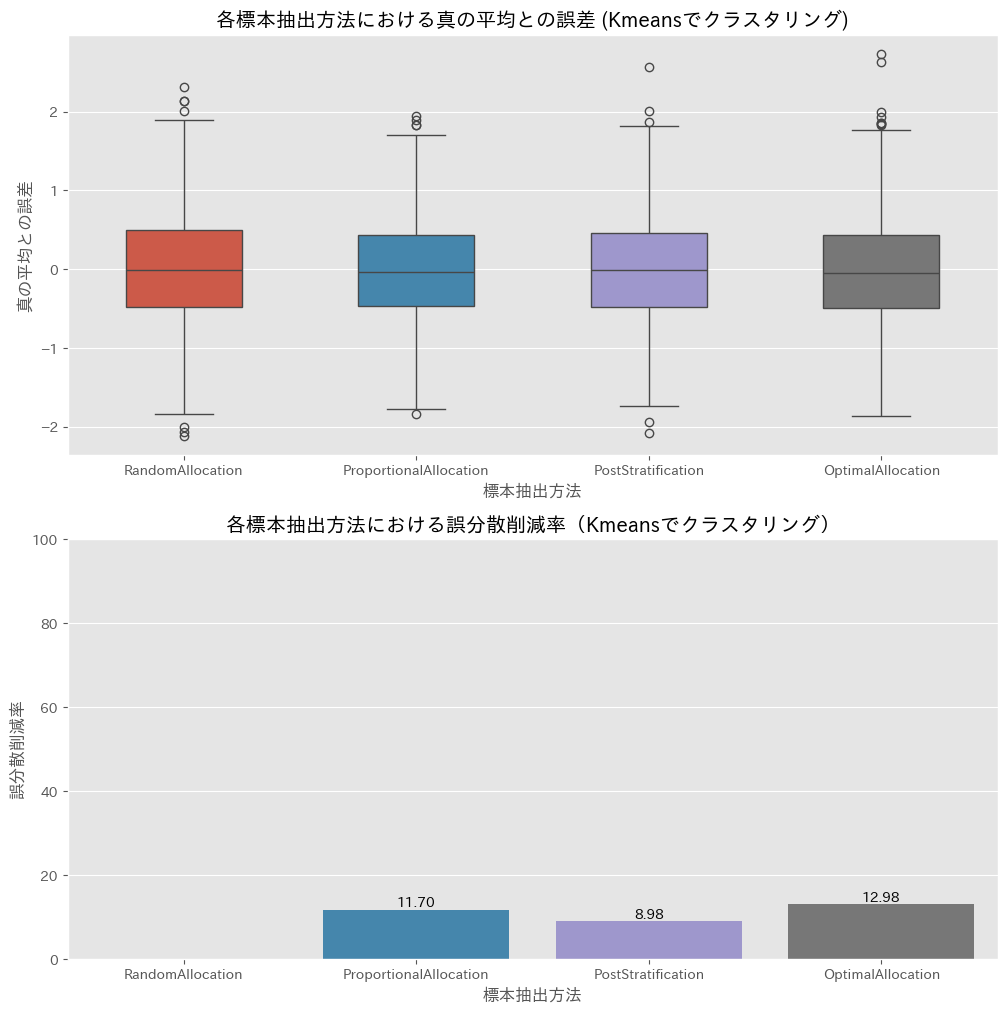

In [20]:
axes: list[plt.Axes]
fig, axes = plt.subplots(2, 1, figsize=(12, 6 * 2))

# 箱ひげ図で誤差の分布を比較
y_hat_df = pd.DataFrame(y_hats)
y_hat_df["error"] = (
    y_hat_df["y_hat"] - y.mean()
)  # 真の平均からの誤差をerrorカラムに追加
sns.boxplot(
    data=y_hat_df,
    y="error",
    x="policy",
    hue="policy",
    ax=axes[0],
    linewidth=1,
    width=0.5,
)
axes[0].set_title("各標本抽出方法における真の平均との誤差 (Kmeansでクラスタリング)")
axes[0].set_ylabel("真の平均との誤差")
axes[0].set_xlabel("標本抽出方法")

# 棒グラフでRandomAllocationに対する誤差分散削減率を比較
# random_allocationの誤差分散
random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
    "error"
].var()
# random_allocation以外の誤差分散
non_random_allocation_std = (
    y_hat_df[y_hat_df["policy"] != "RandomAllocation"].groupby("policy")["error"].var()
)
reduction_rate = (
    1 - non_random_allocation_std / random_allocation_std
) * 100  # 削減率 (%)
## policyの順番をpoliciesの順番に調整
reduction_rate = reduction_rate.reindex(
    [policy.__class__.__name__ for policy in policies]
)
sns.barplot(
    x=reduction_rate.index,
    y=reduction_rate.values,
    ax=axes[1],
    hue=reduction_rate.index,
)
# 棒グラフの上に値を表示
for i, v in enumerate(reduction_rate.values):
    axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_title("各標本抽出方法における誤分散削減率（Kmeansでクラスタリング）")
axes[1].set_ylabel("誤分散削減率")
axes[1].set_xlabel("標本抽出方法")
axes[1].set_ylim(0, 100)

In [24]:
RandomAllocation_df = y_hat_df[y_hat_df["policy"] == "RandomAllocation"]
var_for_RandomAllocation = RandomAllocation_df["error"].var()
ProportionalAllocation_df = y_hat_df[y_hat_df["policy"] == "ProportionalAllocation"]
var_for_ProportionalAllocation = ProportionalAllocation_df["error"].var()
PostStratification_df = y_hat_df[y_hat_df["policy"] == "PostStratification"]
var_for_PostStratification = PostStratification_df["error"].var()
OptimalAllocation_df = y_hat_df[y_hat_df["policy"] == "OptimalAllocation"]
var_for_OptimalAllocation = OptimalAllocation_df["error"].var()

print("Var")
print("Random Allocation:", var_for_RandomAllocation)
print("PropotionalAllocation:", var_for_ProportionalAllocation)
print("PostStratification:", var_for_PostStratification)
print("OptimalAllocation:", var_for_OptimalAllocation)

Var
Random Allocation: 0.3079395468978979
PropotionalAllocation: 0.3096677528165539
PostStratification: 0.3247388924456399
OptimalAllocation: 0.3018623439425935
